In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

In [208]:
# Agregamos la ruta de la carpeta functions:
sys.path.append(os.path.abspath(os.path.join('..', 'functions')))

In [209]:
# Leemos el archivo parquet y lo alojamos en forma DataFrame en la variable movies_dfp 
movies_dfp = pd.read_parquet('../data_post_etl/movies/movies_dataset_etl.parquet')

                                        **Metraje**                                         

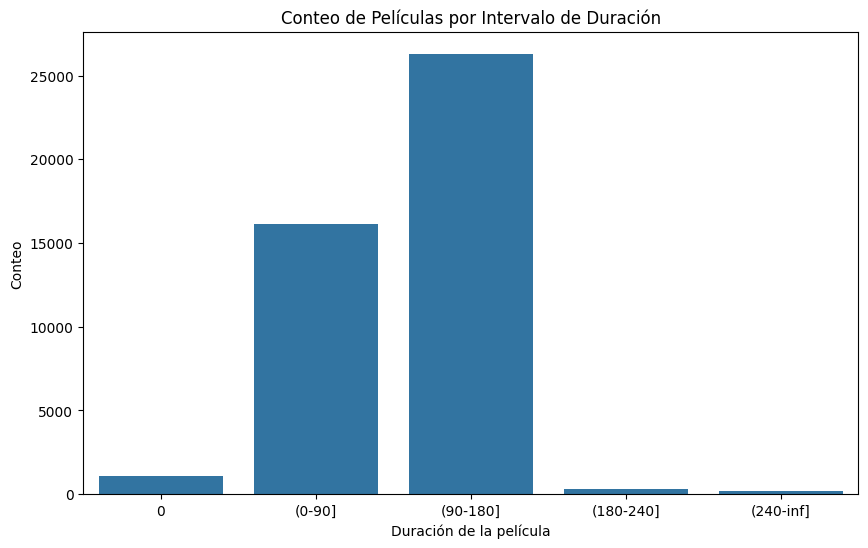

La película con la duración máxima: 1256.0
La película con la duración mínima: 0.0
La media de duración de las peliculas es de 95.13
La mediana de duración de las peliculas es de 95.0
Desviación estándar: 37.49587018454182
Coeficiente de asimetría: 5.003899688021529


In [210]:
# Guardamos la columna 'runtime' (duración de la película) en la variable 'metraje':
metraje = movies_dfp['runtime']

# Eliminamos los valores nulos en 'metraje' para evitar problemas en los cálculos y visualización:
metraje = metraje.dropna()

# Definimos los límites de los intervalos para clasificar las duraciones de las películas:
bins = [float('-inf'), 0, 90, 180, 240, float('inf')]

# Asignamos etiquetas para cada intervalo de duración de las películas:
labels = ['0', '(0-90]', '(90-180]', '(180-240]', '(240-inf]']

# Configuramos el tamaño de la figura para el gráfico de conteo:
plt.figure(figsize=(10, 6))

# Creamos un gráfico de barras que muestra el conteo de películas dentro de cada intervalo de duración:
sns.countplot(data=movies_dfp, x=pd.cut(metraje, bins=bins))

# Etiquetamos los ejes y el título:
plt.xlabel('Duración de la película')
plt.ylabel('Conteo')
plt.title('Conteo de Películas por Intervalo de Duración')

# Cambiamos las etiquetas del eje x para que coincidan con los intervalos definidos en 'labels':
plt.xticks(ticks=range(len(labels)), labels=labels)

# Mostramos el gráfico:
plt.show()

# Imprimimos el maximo, minimo, media, mediana, desviación estandar y el coef de asimetria:
print(f'La película con la duración máxima: {max(metraje)}')
print(f'La película con la duración mínima: {min(metraje)}')
print(f'La media de duración de las peliculas es de {round(np.mean(metraje), 2)}')
print(f'La mediana de duración de las peliculas es de {np.median(metraje)}')
print(f'Desviación estándar: {np.std(metraje)}')
print(f'Coeficiente de asimetría: {metraje.skew()}')


Ya que buscaremos predecir una pelicula borraremos aquellos metrajes que superan las 4 horas considerando que pueden estar dentro del dataset miniseries o series, y en caso de ser peliculas no recomendaremos peliculas más largas de 4 horas ya que no tienden a ser muy bien aceptadas por el público

In [211]:
# Procedemos a borrar los metrajes mayores a 240 minutos:
movies_dfp = movies_dfp[movies_dfp['runtime'] < 240]

In [212]:
# Peliculas con duración igual a 0:
len(movies_dfp[movies_dfp['runtime'] == 0])

1093

Como podemos observar hay 1093 peliculas que tienen una duración de 0 minutos. Por el valor que pueden llegar a tener esos datos, transformaremos su duración a la media de metraje

In [213]:
# Procedemos a reemplazar aquellas peliculas que tengan un metraje igual 0 por la media:
movies_dfp['runtime'] = metraje.replace(0, metraje.mean())

In [214]:
# Confirmamos la transformación:
len(movies_dfp[movies_dfp['runtime'] == 0])

0

In [215]:
# Estos cambios en los valores favorecieron a reducir el sesgo, creando una mayor simetría:
print(f"Coeficiente de asimetría: {movies_dfp['runtime'].skew()}")

Coeficiente de asimetría: -0.1458364153484209


                                        **idioma**                                  

In [216]:
# Observamos el top 10 de las idiomas originales de las películas:
movies_dfp['original_language'].value_counts().head(10)

original_language
en    31669
fr     2247
ja     1335
it     1251
de      950
es      915
ru      763
hi      498
ko      442
zh      402
Name: count, dtype: int64

C:\Users\Julia\AppData\Local\Temp\ipykernel_23132\3321899269.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_idiomas_originales.index, y=top_idiomas_originales.values, palette='viridis')


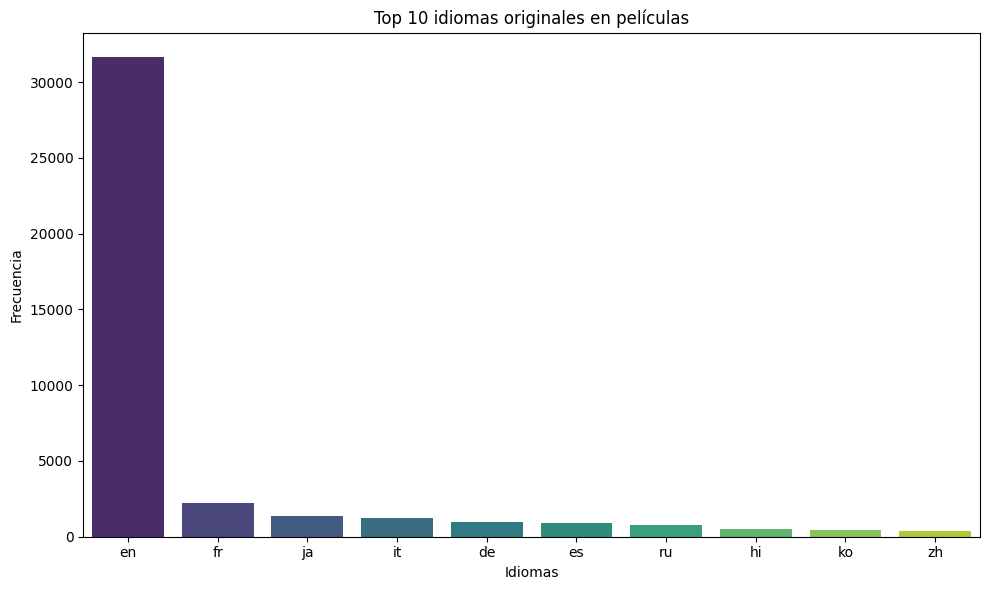

In [217]:
# Hacemos un top 10 idiomas más comunes en 'original_language' y lo alojamos en una variable:
top_idiomas_originales = movies_dfp['original_language'].value_counts().head(10)

# Configuramos el tamaño de la figura:
plt.figure(figsize=(10, 6))

# Creamos un gráfico de barras para los idiomas y sus frecuencias:
sns.barplot(x=top_idiomas_originales.index, y=top_idiomas_originales.values, palette='viridis')

# Configuramos los ejes y el título:
plt.title('Top 10 idiomas originales en películas')
plt.xlabel('Idiomas')
plt.ylabel('Frecuencia')

# Ajustamos el diseño de la figura:
plt.tight_layout()

# Mostramos el gráfico:
plt.show()

Se ve una predominancia muy clara del idioma ingles. Utilizaremos solo el top 3 + el idioma español para optimizar el modelo.

In [218]:
# Seleccionamos las películas a utilizar: 
idiomas_seleccionados = ['en','fr','it','es']

# Filtramos el dataframe quedandonos con los idiomas previamente elegidos:
movies_dfp = movies_dfp[movies_dfp['original_language'].isin(idiomas_seleccionados)]

Al ya estar utilizando los idiomas de las peliculas, no utilizaremos el id de los idiomas en los cuales se trabajo esa pelicula

In [219]:
# Procedemos a borrar la columna spoken_languages_id
movies_dfp.drop(columns='spoken_languages_id', inplace=True)

                                        **Fecha**                                           

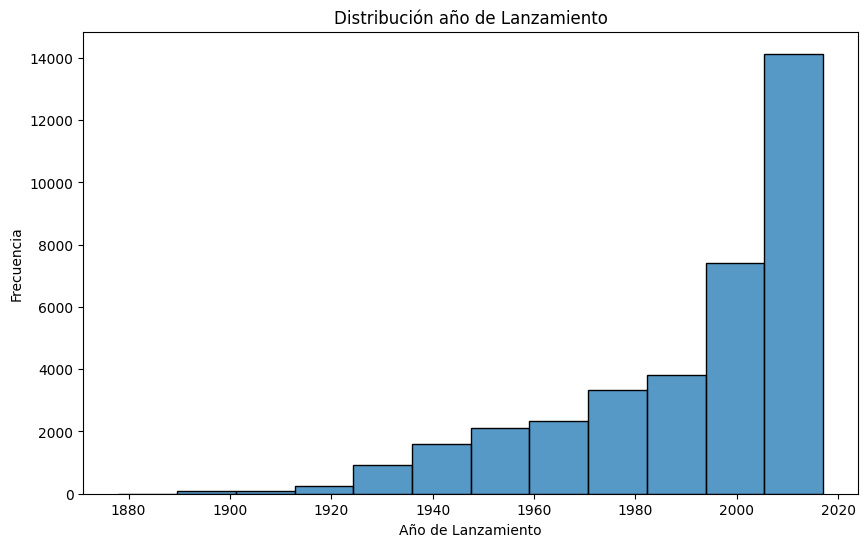

La película más nueva que hay como dato se estrenó en el año: 2017
La película más antigua que hay como dato se estrenó en el año: 1878
La media de año de estreno de una película: 1990.82
La mediana de año de estreno de una película: 2000.0
Desviación estándar: 24.654559237552377
Coeficiente de asimetría: -1.1475711374404083


In [220]:
# Guardamos la columna 'release_year' en la variable 'año':
año = movies_dfp['release_year']

# Configuramos el tamaño de la figura:
plt.figure(figsize=(10, 6))

# Creamos un histograma de la distribución de los años de lanzamiento:
sns.histplot(movies_dfp, x='release_year', bins=12)

# Configuramos los ejes y el título:
plt.title('Distribución año de Lanzamiento')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Frecuencia')

# Mostramos el gráfico:
plt.show()

# Imprimimos el máximo, minimo, la media, mediana, la desviacion estandar y el coef de asimetria
print(f'La película más nueva que hay como dato se estrenó en el año: {max(año)}')
print(f'La película más antigua que hay como dato se estrenó en el año: {min(año)}')
print(f'La media de año de estreno de una película: {round(np.mean(año), 2)}')
print(f'La mediana de año de estreno de una película: {np.median(año)}')
print(f'Desviación estándar: {np.std(año)}')
print(f'Coeficiente de asimetría: {año.skew()}')


Como para el modelo la popularidad va a ser un factor muy importante, considero que va a ser pertinente utilizar las peliculas a partir del 1980

In [221]:
# Procedemos a filtrar el DataFrame por las películas mayores a 1980:
movies_dfp = movies_dfp[movies_dfp['release_year'] > 1980]

In [222]:
# Imprimimos el coeficiente de asimetría de los años de lanzamiento:
print(f'Coeficiente de asimetría: {movies_dfp["release_year"].skew()}')

Coeficiente de asimetría: -0.7201075361820128


                                **Popularidad y Cantidad de Votos**                         

Para poder recomendar una pelicula, se necesita un estandar de evaluación, por eso si no tienen votos y no tienen medida la popularidad procederemos a borrarlas

In [223]:
# Identificamos cuantas filas hay con pupularidad 0 y con vote_count 0:
movies_dfp[((movies_dfp['popularity']== 0) & (movies_dfp['vote_count'] == 0))].shape[0]

426

In [224]:
# Procedemos a filtrar aquellas filas en las que la popularidad y el vote_count son mayores a 0
movies_dfp = movies_dfp[~((movies_dfp['popularity']== 0) & (movies_dfp['vote_count'] == 0))]

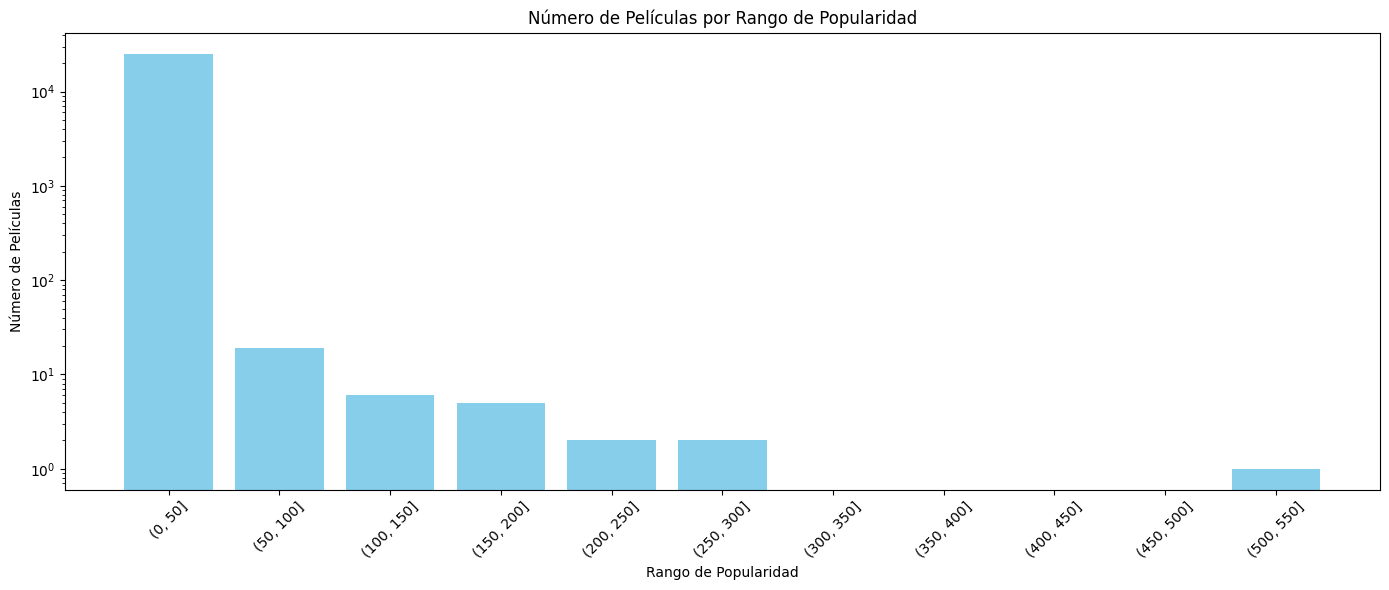

Valor máximo: 547.49
Valor mínimo: 0.0
Media: 3.8972417039303364
Mediana: 1.7
Moda: 0    0.01
Name: popularity, dtype: float64
Desviación estándar: 7.522558617618867
Coeficiente de asimetría: 26.02483710506211


In [225]:
# Guardamos la columna 'popularity' en la variable 'pop':
pop = movies_dfp['popularity']

# Definimos intervalos de popularidad de 50 en 50 para una mejor visualización:
bins = range(0, int(movies_dfp['popularity'].max()) + 50, 50)

# Agrupamos 'popularity' en los intervalos y contamos las películas en cada uno:
popularity_binned = pd.cut(movies_dfp['popularity'], bins=bins).value_counts().sort_index()

# Creamos la figura para el gráfico de barras:
plt.figure(figsize=(14, 6))

# Generamos el gráfico de barras con los rangos de popularidad:
plt.bar(popularity_binned.index.astype(str), popularity_binned.values, color='skyblue')

# Configuramos los ejes y el título:
plt.xlabel('Rango de Popularidad')
plt.ylabel('Número de Películas')
plt.title('Número de Películas por Rango de Popularidad')

# Aplicamos escala logarítmica al eje y para mejorar la visibilidad:
plt.yscale('log')

# Rotamos las etiquetas del eje x para mejorar la legibilidad:
plt.xticks(rotation=45)

# Ajustamos el diseño del gráfico:
plt.tight_layout()

# Mostramos el gráfico:
plt.show()

# Imprimimos el máximo, minimo, la media, mediana, la desviacion estandar y el coef de asimetria:
print(f'Valor máximo: {max(pop)}')
print(f'Valor mínimo: {min(pop)}')
print(f'Media: {np.mean(pop)}')
print(f'Mediana: {np.median(pop)}')
print(f'Moda: {pop.mode()}')
print(f'Desviación estándar: {np.std(pop)}')
print(f'Coeficiente de asimetría: {pop.skew()}')


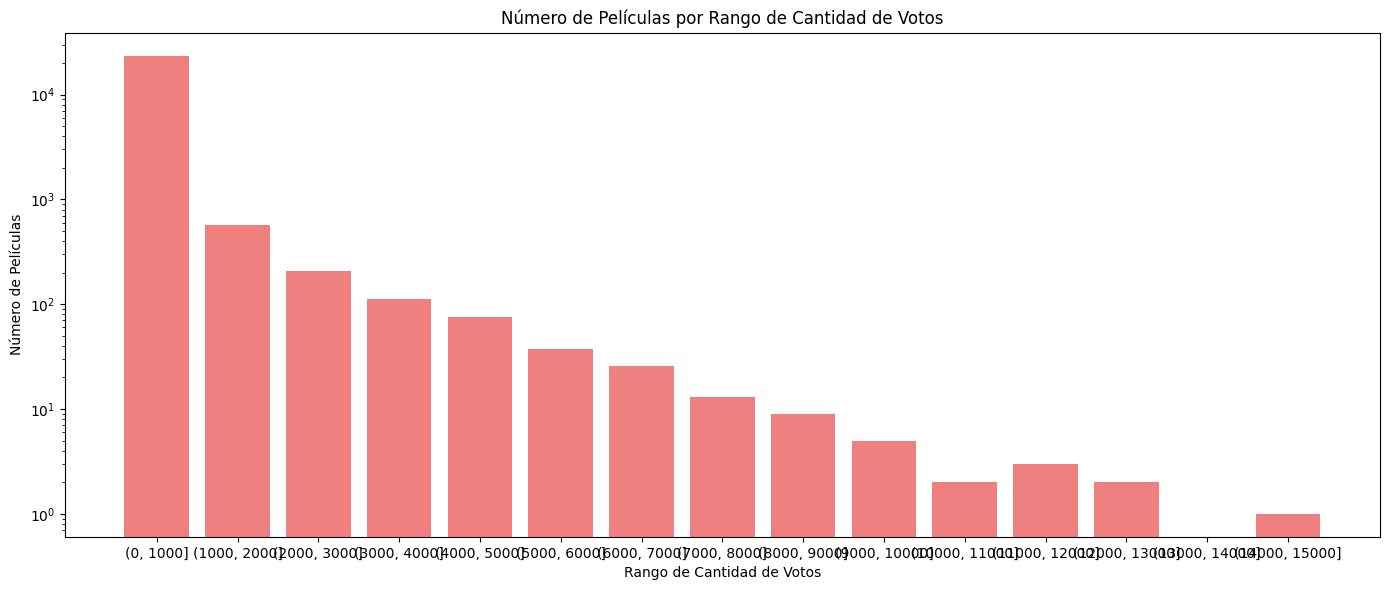

Valor máximo: 14075
Valor mínimo: 0
Media: 173.2929316701969
Mediana: 15.0
Moda: 0    1
Name: vote_count, dtype: int64
Desviación estándar: 635.739065764413
Coeficiente de asimetría: 8.10851928050913


In [226]:
# Guardamos la columna 'vote_count' en la variable 'cantidad_votos':
cantidad_votos = movies_dfp['vote_count']

# Definimos intervalos de cantidad de votos de 1000 en 1000 para una mejor visualización:
bins = range(0, int(movies_dfp['vote_count'].max()) + 1000, 1000)

# Agrupamos 'vote_count' en los intervalos y contamos las películas en cada uno:
vote_count_binned = pd.cut(movies_dfp['vote_count'], bins=bins).value_counts().sort_index()

# Creamos la figura para el gráfico de barras:
plt.figure(figsize=(14, 6))

# Generamos el gráfico de barras con los rangos de cantidad de votos:
plt.bar(vote_count_binned.index.astype(str), vote_count_binned.values, color='lightcoral')

# Configuramos los ejes y el título
plt.xlabel('Rango de Cantidad de Votos')
plt.ylabel('Número de Películas')
plt.title('Número de Películas por Rango de Cantidad de Votos')

# Aplicamos escala logarítmica al eje y para mejorar la visibilidad:
plt.yscale('log')

# Ajustamos el diseño del gráfico:
plt.tight_layout()

# Mostramos el gráfico:
plt.show()

# Imprimimos el máximo, minimo, la media, mediana, la desviacion estandar y el coef de asimetria
print(f'Valor máximo: {max(cantidad_votos)}')
print(f'Valor mínimo: {min(cantidad_votos)}')
print(f'Media: {np.mean(cantidad_votos)}')
print(f'Mediana: {np.median(cantidad_votos)}')
print(f'Moda: {(cantidad_votos.mode())}')
print(f'Desviación estándar: {np.std(cantidad_votos)}')
print(f'Coeficiente de asimetría: {cantidad_votos.skew()}')


Podemos observar qeu tanto la cantidad de votos y la popularidad(elementos muy valiosos para recomendar peliculas) tienen un sesgo positivo muy marcado. Pero las peliculas muy populares y muy votadas nos son valiosas así que las mantendremos


Por otro lado procederemos a quedarnos con los percentiles superiores a Q1 ya que preferimos no utilizar las peliculas poco votadas y muy poco populares

In [227]:
# Procedemos a generar el filtrado:
movies_dfp = movies_dfp[(movies_dfp['vote_count'] > 4) & 
            (movies_dfp['popularity'] > 0.55)]

desestimaremos los los id del pais de las productoras ya que tampoco utilizaremos esa tabla en el modelo, además por el hecho de que no nos sirven los id para el modelo sacaremos también el de btc_id

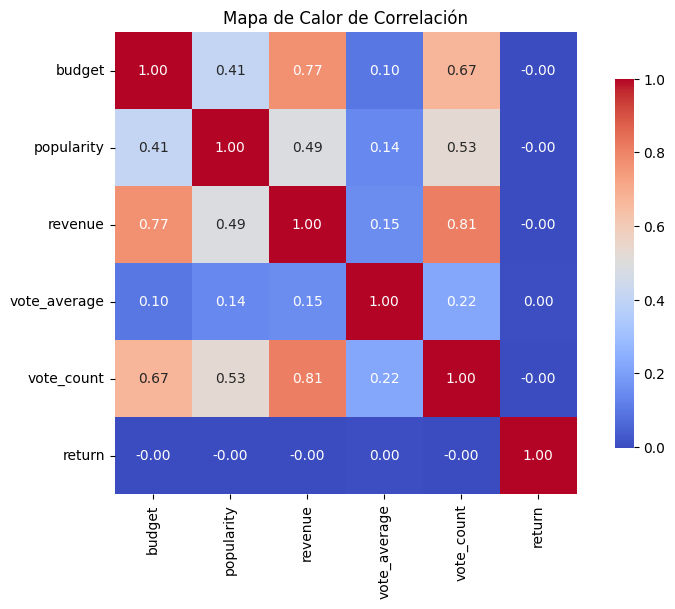

In [228]:
# Seleccionamos las columnas relevantes para el análisis de correlación:
cols_mapa_calor = movies_dfp[['budget', 'popularity', 'revenue', 'vote_average', 'vote_count', 'return']]

# Calculamos la matriz de correlación de las columnas seleccionadas:
matriz_correlación = cols_mapa_calor.corr()

# Creamos una figura para el mapa de calor:
plt.figure(figsize=(10,6))

# Generamos el mapa de calor utilizando la matriz de correlación:
sns.heatmap(matriz_correlación, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})

# Añadimos un título al gráfico:
plt.title('Mapa de Calor de Correlación')

# Mostramos el gráfico:
plt.show()


En primera instancia se peude observar que mientras mayor rédito en la pelicula hay una tendencia a que se más popular y una mayor tendencia a dicha película sea votada, además un gran redito por lo general, es predecedida por una gran inversión. Lo que parecería indicar que mientras más inversión es más probable que haya una mayor ganancia.

También podemos observar que la variable return tiene una correlación nula con el resto de variables

In [229]:
#movies_dfp.drop(columns=['budget', 'return'], inplace=True)

                                **Preprocesamiento de los datos**                                                    

In [230]:
# Importamos la biblioteca Natural Language Toolkit
import nltk

# Generamos la ruta:
nltk.data.path.append('b:/proyecto_individual_1/venv') 

# Descargar recursos necesarios:
nltk.download('punkt_tab', download_dir='b:/proyecto_individual_1/venv')
nltk.download('stopwords', download_dir='b:/proyecto_individual_1/venv')
nltk.download('wordnet', download_dir='b:/proyecto_individual_1/venv')
nltk.download('averaged_perceptron_tagger_eng', download_dir='b:/proyecto_individual_1/venv')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     b:/proyecto_individual_1/venv...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     b:/proyecto_individual_1/venv...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     b:/proyecto_individual_1/venv...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     b:/proyecto_individual_1/venv...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Pasamos a tokenizar a la columna overview la cual posee un resumen de todas las peliculas, la cual nos va a servir de eje a la hora de predecir las peliculas recomendadas.

In [231]:
#Importamos la función para tokenizar la columna overview
from tokenizador import tokenizar

# Aplicamos la función tokenizar:
movies_dfp['overview'] = movies_dfp['overview'].apply(tokenizar)

Lo que haremos ahora es unir al DataFrame genres después de algunas modificaciones y luego la utilizaremos para añadirle peso la columna overview para que se tenga en cuenta el genenero a la hora de predecir

In [232]:
# Procedemos a leer el archivo genres.parquet:
genres = pd.read_parquet('../data_post_etl/movies/genres.parquet')

In [233]:
# El id de la tabla genres no me sirve así que lo borramos:
genres.drop(columns='id', inplace=True)

In [234]:
# Observamos la cantidada de NaN que posee la tabla:
genres['name'].isna().sum()

np.int64(2135)

In [235]:
# Llenamos con cadenas vacías donde hay NaNs:
genres.name = genres['name'].fillna('')

In [236]:
# Improtamos la función normalizar:
from normalizador import normalizar

# Procedemos a normalizar la columna name del DataFrame genres:
genres['name'] = genres['name'].apply(normalizar)

In [237]:
# Filtramos el DataFrame genres con los id existentes en movies_dfp
genres = genres[genres['genres_id'].isin(movies_dfp['genres_id'])]

In [238]:
# Agrupamos los generos por nombres y los alojamos en un nuevo DataFrame: 
nombre_generos = genres.groupby('genres_id')['name'].apply(lambda x: ' '.join(x)).reset_index()

# Cambiamos los nombres de las columnas:
nombre_generos.columns = ['genres_id', 'nombre_generos']

In [239]:
# Realizamos el merge al DataFrame movies_dfp con el recientemente creado:
movies_dfp = movies_dfp.merge(nombre_generos, on='genres_id', how='left')
movies_dfp = movies_dfp.drop('genres_id', axis=1)

In [240]:
#Importa la funcion combinar_peso
from peso import combinar_peso

# Combinamos 'overview' con 'nombre_generos' ponderado, usando peso 2:
movies_dfp['predictor'] = movies_dfp.apply(lambda fila: combinar_peso(fila, 'nombre_generos', peso=2), axis=1)

Haremos lo mismo con el DataFrame cast ya que dandole peso a los actores tendremos en cuenta a los actores que por lo general actuan en los mismos generos y lo más importante que se tendran en cuenta sagas, trilogías, etc. Al contar con al menos parte del mismo elenco en las peliculas.

In [241]:
# Leemos el archivo cast_transfomados.parquet
cast = pd.read_parquet('../data_post_etl/credits/cast_transformados.parquet')

In [242]:
# Borramos aquellas columnas innecesarias:
cast = cast.drop('id', axis=1)
cast = cast.drop('cast_id', axis=1)

In [243]:
# Procedemos a normalizar la columna name del DataFrame normalizar_texto:
cast['name'] = cast['name'].apply(normalizar)

In [244]:
# Filtramos el DataFrame cast con los id existentes en movies_dfp
cast = cast[cast['id_credits'].isin(movies_dfp['id'])]

In [245]:
# Agrupamos los generos por nombres y los alojamos en un nuevo DataFrame: 
actores = cast.groupby('id_credits')['name'].apply(lambda x: ' '.join(x)).reset_index()

# Cambiamos los nombres de las columnas:
actores.columns = ['id', 'actores']

In [246]:
# Realizamos el merge al DataFrame movies_dfp con el recientemente creado:
movies_dfp = movies_dfp.merge(actores, on='id', how='left')

In [247]:
# Combina 'overview' con 'actores' ponderado, usando peso 1:
movies_dfp['predictor'] = movies_dfp.apply(lambda fila: combinar_peso(fila, 'actores', peso=1), axis=1)

In [248]:
# Creamos el DataFrame con las columnas que utilizaremos para predecir:
modelo_prediccion = movies_dfp[['title','predictor']]

In [249]:
# Reseeteamos el index del nuevo DataFrame:
modelo_prediccion = modelo_prediccion.reset_index(drop=True)

In [250]:
# Definimos la ruta de guardado y combinamos el DataFrame en formato parquet:
ruta = os.path.join('../data_post_etl/prediccion/', 'modelo_prediccion.parquet')

# Guardamos 'modelo_prediccion' en la ruta especificada en formato parquet
modelo_prediccion.to_parquet(ruta, engine='pyarrow', index=False)